<h3><center>Introduction to building a quant pricing library</center></h3>
<h1><center>Volatility surface, numerical greeks</center></h1>
<h3><center>Gabor Friedmann</center></h3>
<h4><center>19 March, 2025</center></h4>

<b>Law of supply and demand:</b>
* Market price of face masks during covid
* Market price of options (quotes)

<b>Goal of option pricing:</b>
* Come up with a model that is able to re-price "frequently" traded products
* Use the model to understand how to eliminate risks (hedging)
* Use the model to price other, "non-frequently" traded products

# Moneyness

Measures whether the option would make money if it were exercised immediately. We define moneyness as current spot price divided by strike price:
$$ M = \dfrac{S_t}{K} $$

At $M = 1$, the option is called at-the-money (ATM). Otherwise, the option is called either in-the-money (ITM) or out-of-the-money (OTM).

<img src="./img/moneyness.jpg" style="margin-left:auto; margin-right:auto; width: 1000px;" />

## What did we learn?

Black-Scholes model assumptions:
* Underlying asset price follows GBM:

$$ dS_{t}=\mu S_{t}\,dt+\sigma S_{t}\,dW_{t} $$

* Underlying asset price has <b>known and constant</b> volatility ($\sigma$)
* Returns of the underlying asset are normally distributed

# Which volatility to pick?

$$ c_0 = f_{BS}\left(S_0, K, T, r, \color{red}{\sigma}\right) $$

$$ \color{red}{\sigma} = f^{-1}_{BS}\left(S_0, K, T, r, c_0\right) $$

<b>Implied volatility</b>: The volatility obtained from market quotes using Black-Scholes formula. It represents what the market is implying the volatility will be in the future based on option prices.

Based on BS assumptions, implied volatility should be constant for all options on a given underlying. Is that true?

<img src="./img/implied_vol_smile.jpg" style="margin-left:auto; margin-right:auto; width: 1500px;" />

<img src="./img/smile_skew.jpg" style="margin-left:auto; margin-right:auto; width: 1500px;" alt="Source: https://analystprep.com/study-notes/frm/part-2/market-risk-measurement-and-management/volatility-smiles/" />

## Why?

Highligting just one concept: Protective Put Option Strategy

There is high demand for put options with low strike as they serve as a protection against huge losses.

<img src="./img/protective_put.jpg" style="margin-left:auto; margin-right:auto; width: 400px;" />


<img src="./img/implied_vol_termskew.jpg" style="margin-left:auto; margin-right:auto; width: 1500px;" />

<b>Conclusion</b>: The volatility depends on strike and expiry: $ \sigma = \sigma(K,T) $

Using market quotes, we can derive an <b>implied volatility grid</b>. Applying some interpolation technique between grid points we can build an <b>implied volatility surface</b>.

Let's look at some examples!

BlueChip Bank, TipTop Solutions, Money Mall


In [1]:
# Add current folder and QuantCourseBP folder to syspath to import modules
import sys
from pathlib import Path
current = Path(Path().resolve())
sys.path.append(str(current))
sys.path.append(str(current.parents[2]))

from src.utils import *
from src.market_data import *

# Make charts interactive - remove this line if charts throws error
%matplotlib notebook

# Initialize market data
MarketData.initialize()

QuantCourseBP 5baa6eade5cd01a3e710a4823b70930c8c583e91*


In [5]:
underlying = Stock.BLUECHIP_BANK
volgrid = MarketData.get_volgrid()[underlying]

<IPython.core.display.Javascript object>


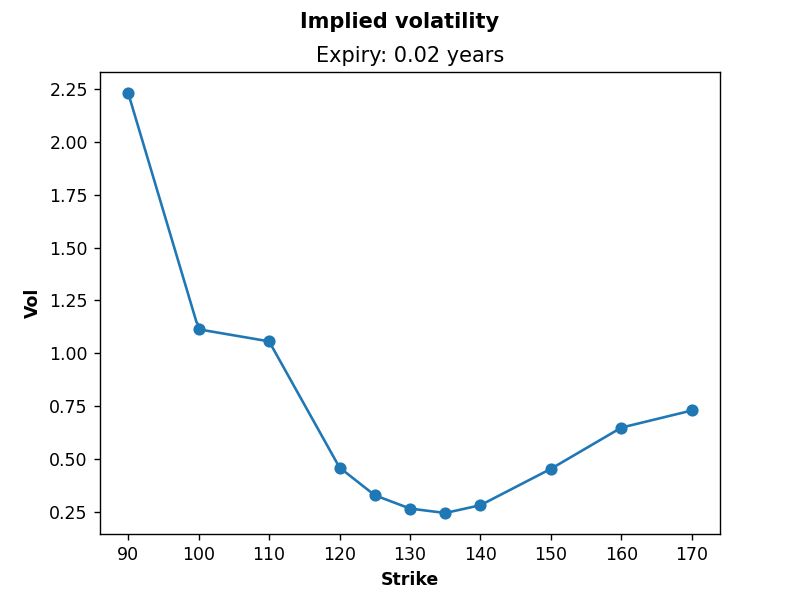

<IPython.core.display.Javascript object>


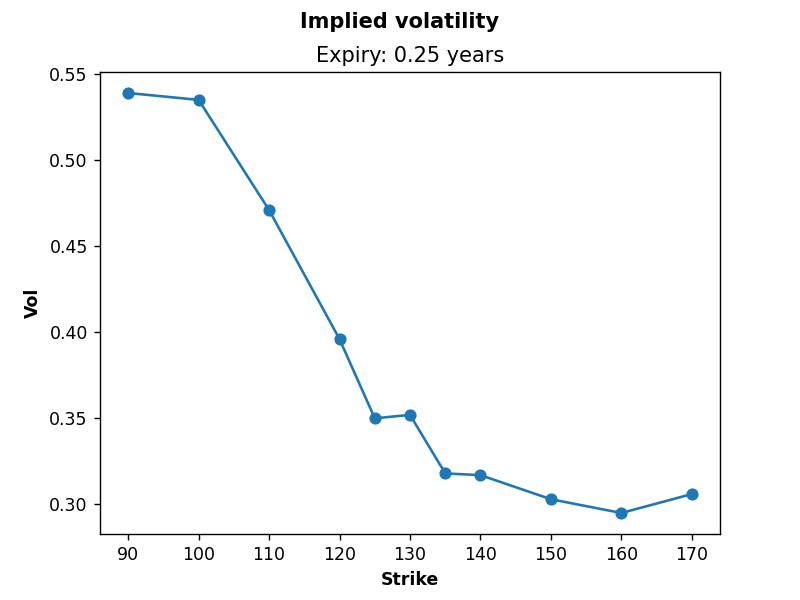

<IPython.core.display.Javascript object>


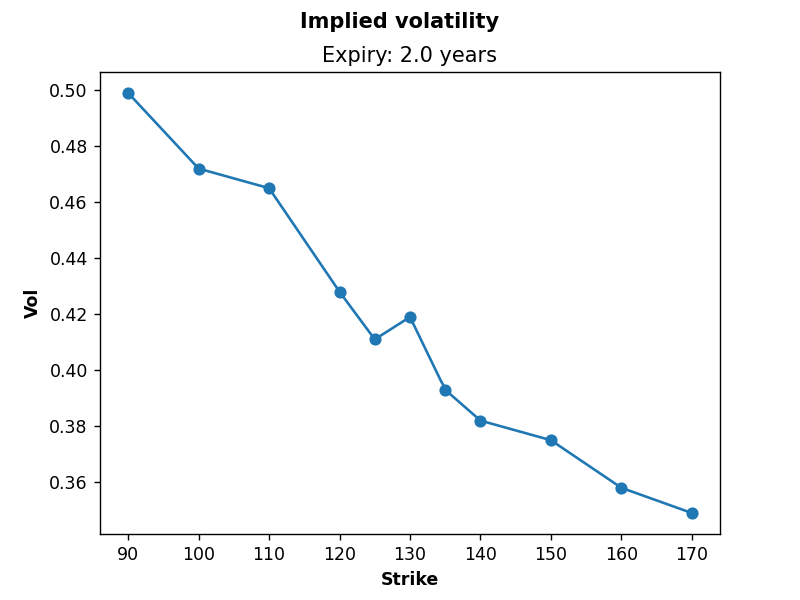

In [4]:
flag = True
plot_vol_slice(volgrid, expiry=0.02, linear_interpolation=flag) # 7D
plot_vol_slice(volgrid, expiry=0.25, linear_interpolation=flag) # 3M
plot_vol_slice(volgrid, expiry=2.00, linear_interpolation=flag) # 2Y

<IPython.core.display.Javascript object>


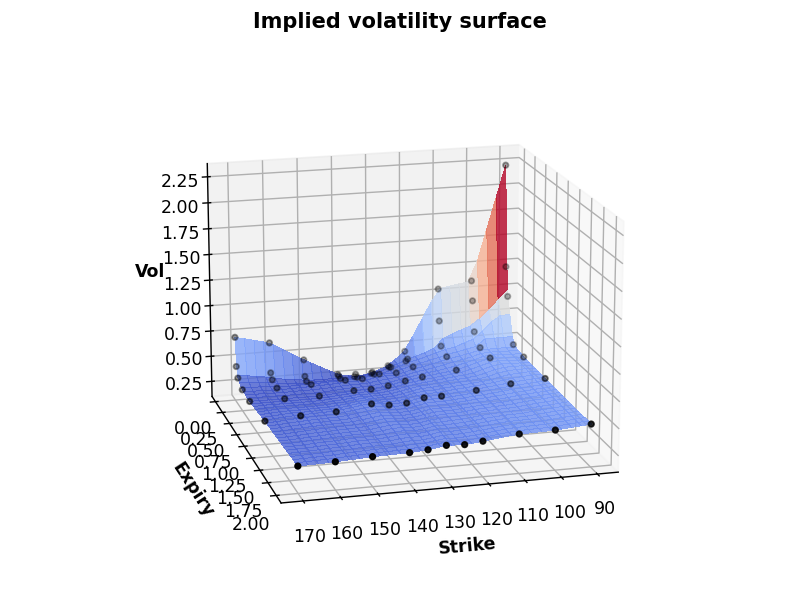

In [5]:
plot_vol_surface(volgrid)

## What changes?

Underlying asset price diffusion:
$$ \; dS_{t}=\mu S_{t}\,dt+\sigma S_{t}\,dW_{t} $$


$$ \; dS_{t}=\mu S_{t}\,dt+\color{red}{\sigma(K,T)} S_{t}\,dW_{t} $$

We can determine $ \sigma(K,T) $ based on the contract we want to price, then use that constant within the Black-Scholes framework. Let's call this extension of BS model as <b>flat volatility model</b>.

Volatility market data is no longer a single number, but a tabular data (grid) for each underlying, hence we outsource them to csv files for maintainability.

<br>
<br>

Let's do coding!

# Tasks

## MarketData - market_data.py

* Understand the new structure of MarketData class
* Understand how VolGrid class works

## MarketModel - model.py

* Implement BSVol and FlatVol models in the pricing library

## Jupyter notebook

* Price a few contracts using both Black-Scholes and FlatVol models

In [2]:
# Add current folder and QuantCourseBP folder to syspath to import modules
import sys
from pathlib import Path
current = Path(Path().resolve())
sys.path.append(str(current))
sys.path.append(str(current.parents[2]))

from src.market_data import *
from pricer import *

# Initialize market data
MarketData.initialize()

In [7]:
coordinate = np.array([(120,2.0)]) #strike price és maturity
MarketData.get_volgrid()[Stock.BLUECHIP_BANK].get_vol(coordinate)[0]

0.428

In [17]:
bs_model = BSVol(Stock.BLUECHIP_BANK)
bs_model.get_vol(109,2) #bárhogy írogatom át a számokat, ugyanazt kapom vissza, hiszen nem tudom override-olni

0.38083000000000006

In [3]:
flat_vol_model = FlatVol(Stock.BLUECHIP_BANK)
flat_vol_model.get_vol(100,1.5) #itt mindig mást kapunk

0.478

In [4]:
und = Stock.BLUECHIP_BANK
put_call = PutCallFwd.CALL
ls = LongShort.LONG
strk = 1.0 * MarketData.get_spot()[und]  # at-the-money strike i.e. strike = spot price
exp = 0.5

forward = ForwardContract(und, ls, strk, exp)
option = EuropeanContract(und, put_call, ls, strk, exp)

print(option)

{'underlying': <Stock.BLUECHIP_BANK: 'BLUECHIP_BANK'>, 'type': <PutCallFwd.CALL: 'CALL'>, 'long_short': <LongShort.LONG: 'LONG'>, 'strike': 130.17, 'expiry': 0.5}


In [5]:
model1 = BSVol(und)
model2 = FlatVol(und)
p = EuropeanAnalyticPricer(option, model1, Params())
p.calc_fair_value()

15.435821042038157

In [6]:
#itt a flat volatility modellt használjuk, tehát más árat is kapunk
#magamnak: próbáljam ki ezt a modellt úgy, hogy ugyanazt a vol.-t adom meg a BS_vol-nak, mint ami ehhez tartozik, és nézzük meg, vajon ugyanazt kapom-e
p = EuropeanAnalyticPricer(option, model2, Params())
p.calc_fair_value()

13.914054182679813

# Greeks

* Understanding the sensitivities of a porfolio is crutial to eliminate them (hedging)
* So far we had analytical formulas to calculate greeks, usually this is not the case
* In most cases we calculate greeks numerically using finite difference approximation (forward, backward, central)

## Finite difference approximation (central, absolute)
$$ f'(x)\approx\dfrac{f(x+\Delta)-f(x-\Delta)}{2\Delta} $$

$$ f''(x)\approx\dfrac{f'(x+\dfrac{\Delta}{2})-f'(x-\dfrac{\Delta}{2})}{\Delta}\approx\dfrac{f(x+\Delta)-2f(x)+f(x-\Delta)}{\Delta^2} $$

# Tasks

## Pricer - pricer.py

* Implement calc_delta() function using finite difference approximation.
* Compare the results of analytic and numerical formulas for delta and gamma.

In [7]:
p.calc_delta(GreekMethod.ANALYTIC)

0.588666805544619

In [8]:
p.calc_delta(GreekMethod.BUMP)

0.5886143267684252

In [11]:
fwd = ForwardContract(und, ls, strk, exp)
p_fwd = ForwardAnalyticPricer(fwd, model1, Params())
p_fwd.calc_delta(GreekMethod.ANALYTIC)

1.0

In [12]:
p_fwd.calc_delta(GreekMethod.BUMP)

1.0000000000000084

# Assignments - Numerical greeks

1. Introduce two class variables in Pricer that store the finite difference method (forward, backward, central) to be used in numerical greek calculation, and whether the bump size is absolute or relative. Create two Enums to store the labels. Implement all combinations for delta and gamma calculation.<br>Compare greeks using the analytic and the finite difference approximation on a set of European options and visualize the numerical error. Compare absolute and relative bumping and suggest optimal bump sizes. **(15 points)**